### Find wavelet transform of the image and use it as a feature for traning the model

In [160]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import pywt

In [161]:
def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

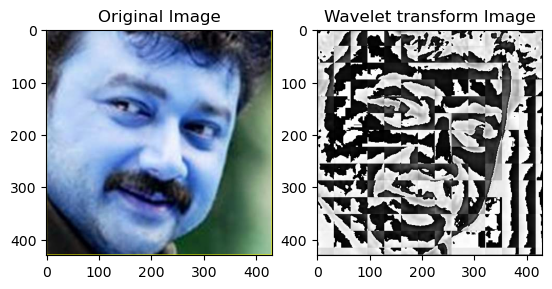

In [162]:
img = cv2.imread(r"C:\Users\User\OneDrive\ANACONDA\Proj_09_Malayalam_Movie_Actors_Recognition\Actors_dataset\Cropped\Jayaram\Jayaram1.png")
img_wt = w2d(img,'db1',5)
plt.subplot(1,2,1)
plt.title('Original Image')
plt.imshow(img)
plt.subplot(1,2,2)
plt.title('Wavelet transform Image')
plt.imshow(img_wt, cmap='gray')

#### Preperation of dataset in X and y format

In [163]:
X, y = [], []
cropped_dir = r"C:\Users\User\OneDrive\ANACONDA\Proj_09_Malayalam_Movie_Actors_Recognition\Actors_dataset\Cropped"
class_data = ['Jayaram','Mammootty','Mohanlal','Mukesh']

for i in range(0,4):
    cropped_actor_dir = cropped_dir + '\\'+ class_data[i]
    for entry in os.scandir(cropped_actor_dir):
        raw_img = cv2.imread(entry.path)
        scaled_raw_img = cv2.resize(raw_img, (32, 32))
        wt_img = w2d(raw_img,'db1',5)
        scaled_wt_img = cv2.resize(wt_img, (32, 32))
        combined_img = np.vstack((scaled_raw_img.reshape(32*32*3,1),scaled_wt_img.reshape(32*32,1)))
        X.append(combined_img)
        y.append(class_data.index(class_data[i])) 
        

In [164]:
X[0]

array([[ 55],
       [ 52],
       [ 60],
       ...,
       [244],
       [  4],
       [244]], dtype=uint8)

In [165]:
len(X[0])

4096

In [166]:
y[0]

0

In [167]:
X = np.array(X).reshape(len(X),4096).astype(float)
X.shape

(232, 4096)

Training data in X and y format is ready. Next step is to train the model

In [178]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
print(len(X_train))
print(len(X_test))

174
58


In [179]:
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.pipeline import Pipeline

In [180]:
pipeline_lr  = Pipeline([('scalar1',StandardScaler()),
                         ('lr',LogisticRegression())])

pipeline_knn = Pipeline([('scalar2',StandardScaler()),
                          ('knn',KNeighborsClassifier())])

pipeline_svc = Pipeline([('scalar3',StandardScaler()),
                         ('svc',SVC(C=10, kernel='linear'))])

pipeline_dt = Pipeline([('dt',DecisionTreeClassifier())])
pipeline_rf = Pipeline([('rf',RandomForestClassifier(max_depth=3))])
pipeline_gb = Pipeline([('gb',GradientBoostingClassifier())])

In [181]:
pipelines = [pipeline_lr,
            pipeline_knn,
            pipeline_svc,
            pipeline_dt,
            pipeline_rf,
            pipeline_gb]
pipelines

[Pipeline(steps=[('scalar1', StandardScaler()), ('lr', LogisticRegression())]),
 Pipeline(steps=[('scalar2', StandardScaler()), ('knn', KNeighborsClassifier())]),
 Pipeline(steps=[('scalar3', StandardScaler()),
                 ('svc', SVC(C=10, kernel='linear'))]),
 Pipeline(steps=[('dt', DecisionTreeClassifier())]),
 Pipeline(steps=[('rf', RandomForestClassifier(max_depth=3))]),
 Pipeline(steps=[('gb', GradientBoostingClassifier())])]

In [182]:
for pipe in pipelines:
    pipe.fit(X_train,y_train)

C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [183]:
pipe_dict = {0:'LR',
             1:'KNN',
             2:'SVC',
             3:'DT',
             4: 'RF',
             5: 'GBC'}
pipe_dict

{0: 'LR', 1: 'KNN', 2: 'SVC', 3: 'DT', 4: 'RF', 5: 'GBC'}

In [184]:
for i,model in enumerate(pipelines):
    print("{} Test Accuracy:{}".format(pipe_dict[i],model.score(X_test,y_test)*100))

LR Test Accuracy:70.6896551724138
KNN Test Accuracy:53.44827586206896
SVC Test Accuracy:74.13793103448276
DT Test Accuracy:44.827586206896555
RF Test Accuracy:50.0
GBC Test Accuracy:63.793103448275865


This shows that LR and SVC performs better compared to other models

### Hypertuning using Random Search CV

In [211]:
from sklearn.model_selection import RandomizedSearchCV

svc_grid = {'C':[0.25,0.50,0.75,1,5,10,25,50,75,85,100],"kernel":["linear","rbf"]}
lr_grid={"C":np.logspace(1,10,20),"solver":['liblinear']}

rs_svc=RandomizedSearchCV(SVC(),
                  param_distributions=svc_grid,
                   cv=5,
                   n_iter=20,
                  verbose=True)

rs_lr=RandomizedSearchCV(LogisticRegression(),
                   param_distributions=lr_grid,
                  n_iter=20,cv=5,verbose=True)

In [212]:
st = StandardScaler()
X_train =st.fit_transform(X_train)

In [213]:
rs_svc.fit(X_train,y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=SVC(), n_iter=20,
                   param_distributions={'C': [0.25, 0.5, 0.75, 1, 5, 10, 25, 50,
                                              75, 85, 100],
                                        'kernel': ['linear', 'rbf']},
                   verbose=True)

In [214]:
rs_lr.fit(X_train,y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_iter=20,
                   param_distributions={'C': array([1.00000000e+01, 2.97635144e+01, 8.85866790e+01, 2.63665090e+02,
       7.84759970e+02, 2.33572147e+03, 6.95192796e+03, 2.06913808e+04,
       6.15848211e+04, 1.83298071e+05, 5.45559478e+05, 1.62377674e+06,
       4.83293024e+06, 1.43844989e+07, 4.28133240e+07, 1.27427499e+08,
       3.79269019e+08, 1.12883789e+09, 3.35981829e+09, 1.00000000e+10]),
                                        'solver': ['liblinear']},
                   verbose=True)

In [297]:
print(rs_svc.best_score_)
print(rs_svc.best_params_)
print(rs_lr.best_score_)
print(rs_lr.best_params_)

0.735126050420168
{'kernel': 'linear', 'C': 5}
0.7757983193277311
{'solver': 'liblinear', 'C': 784.7599703514607}


### Hypertuning using GridSearchCV

In [253]:
from sklearn.model_selection import GridSearchCV

svc_grid1 = {'C':[1,10,50,100],"kernel":["linear","rbf"]}
lr_grid1={"C":(1,5,10),"solver":['liblinear']}

gs_svc =GridSearchCV(SVC(),
                  param_grid=svc_grid1,
                   cv=5,
                   verbose=True)
gs_lr =GridSearchCV(LogisticRegression(),
                  param_grid=lr_grid1,
                   cv=5,
                   verbose=True)

In [254]:
gs_svc.fit(X_train,y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [1, 10, 50, 100], 'kernel': ['linear', 'rbf']},
             verbose=True)

In [255]:
gs_lr.fit(X_train,y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': (1, 5, 10), 'solver': ['liblinear']},
             verbose=True)

In [298]:
print(gs_svc.best_score_)
print(gs_svc.best_params_)
print(gs_lr.best_score_)
print(gs_lr.best_params_)

0.735126050420168
{'C': 1, 'kernel': 'linear'}
0.7640336134453782
{'C': 10, 'solver': 'liblinear'}


### Selection of best model

In [258]:
best_score=[]
best_params=[]
model = [rs_svc, rs_lr, gs_svc, gs_lr]
i=0
for i in range(4):
    best_score.append(model[i].best_score_)
    best_params.append(model[i].best_params_)

In [259]:
best_score

[0.735126050420168, 0.7757983193277311, 0.735126050420168, 0.7640336134453782]

In [260]:
best_params

[{'kernel': 'linear', 'C': 5},
 {'solver': 'liblinear', 'C': 784.7599703514607},
 {'C': 1, 'kernel': 'linear'},
 {'C': 10, 'solver': 'liblinear'}]

In [261]:
import pandas as pd
df = pd.DataFrame({"Model":model,"Best score": best_score, "Best Params":best_params})
df

,Model,Best score,Best Params
0,"RandomizedSearchCV(cv=5, estimator=SVC(), n_it...",0.735126,"{'kernel': 'linear', 'C': 5}"
1,"RandomizedSearchCV(cv=5, estimator=LogisticReg...",0.775798,"{'solver': 'liblinear', 'C': 784.7599703514607}"
2,"GridSearchCV(cv=5, estimator=SVC(),\n ...",0.735126,"{'C': 1, 'kernel': 'linear'}"
3,"GridSearchCV(cv=5, estimator=LogisticRegressio...",0.764034,"{'C': 10, 'solver': 'liblinear'}"


In [288]:
best_model_index = df.loc[df['Best score']==max(df['Best score'])].index[0]
best_model = df._get_value(best_model_index,'Model')

### Plot Confusion matrix

In [289]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_model.predict(X_test))
cm

array([[10,  0,  0,  0],
       [ 2,  5,  3,  1],
       [ 2,  1, 16,  0],
       [ 1,  6,  2,  9]], dtype=int64)

Text(33.22222222222222, 0.5, 'Truth')

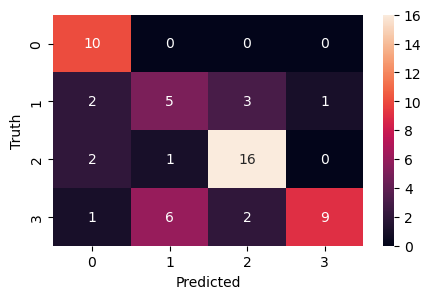

In [296]:
import seaborn as sn
plt.figure(figsize = (5,3))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

### Save the trained model as pickle

In [ ]:
import joblib 
# Save the model as a pickle in a file 
joblib.dump(best_model, 'actor_model.pkl') 

The trained model is successfully saved in the directory